Opening files: 
/cluster/work/users/rheinlender/breakup2013/WRF-exp/outputs/expt_01_wrf10km/Moorings.nc
/cluster/home/rheinlender/projects/aoi_case_study/python/plots/wrf/animate_hfs_expt_01_wrf10km.gif
create animation


MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

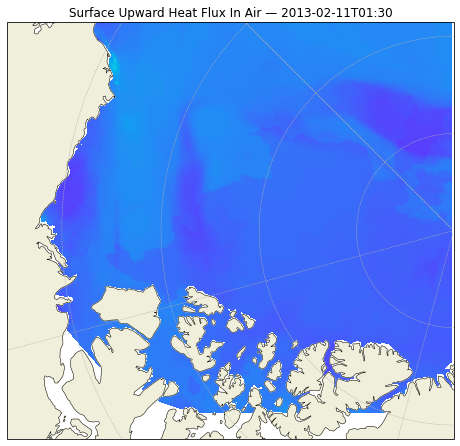

In [19]:
#! /bin/bash
# allow plots to be interactive in the notebook
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import os 
import sys
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import cartopy 
import cartopy.crs as ccrs
import pyproj
from pynextsim.projection_info import ProjectionInfo
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image

# inputs to animation
var='hfs' # choose what variable to plot
k=0
exp = ['expt_01_wrf10km']
inpath ='/cluster/work/users/rheinlender/breakup2013/WRF-exp/outputs/'+exp[k]+'/'
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/plots/wrf/'
outname = outpath_plots+'animate_' + var + '_' + exp[k] + '.gif'

fl = sorted(glob(inpath+'Moorings*.nc'))
print('Opening files: ', *fl, sep = "\n") 
print(outname)

# Open multiple nc files
ds = xr.open_mfdataset(fl, concat_dim='time')

# select smaller domain
ds=ds.sel(x=slice(0,450), y=slice(50, 500))

# get latitude and longitude 
lons = ds['longitude']
lats = ds['latitude']

# Select time slice
start_date = ds.time[0]
end_date = ds.time[-1]
subset = ds.sel(time=slice(start_date, end_date))

varin = subset[var]

# compute daily averages 
#varin = subset[var].groupby('time.dayofyear').mean(skipna=True)

# get time array
dates = subset['time']

##### Prepare animation #####

# set projection 
proj = ProjectionInfo() # default nextsim projection
crs=proj.crs

# choose what domain to plot
extent = [-110, 200, 65, 90]   #zoom on Beaufort Sea

# Get x-y grid from model
x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]] 
y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
ex_lim=1
x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

# set colomap
#cmap = 'viridis'
cmap = 'rainbow'

# contour levels
#clevs = np.arange(0.,3.1,0.1)
clevs = np.arange(0.,250,1)


#frames = len(dates)        # Number of frames
frames = 10        # test

# Create animation
print('create animation')

def make_figure():
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection=crs, extent=extent)
    
    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1)
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=1,linestyle="--")
    
    return fig, ax

fig, ax = make_figure();

def draw(frame):

    # Plot contour
    cs=ax.contourf(varin[frame], zorder=1, extent=[*x_extent, *y_extent],levels=clevs,cmap=cmap, extend='max')

    # add title inside subplots
    title = u"%s — %s" % (ds[var].long_name, str(dates[frame].values)[:16])
    ax.set_title(title)
    
    return cs

def init():
    Z=varin[0]
    cs=ax.contourf(Z, zorder=1, extent=[*x_extent, *y_extent],levels=clevs,cmap=cmap, extend='max')
    
    title = u"%s — %s" % (ds[var].long_name, str(dates[0].values)[:16])
    ax.set_title(title)
    
   # cbar=add_colorbar(fig, ax, cs)
    
    return cs,

def add_colorbar(fig, ax, cs):
    cb_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(cs, cax=cb_ax)   
    return cbar

def update(frame, cs):
    '''
    This is where our contour is updated
    '''
    Z = varin[frame]

    cs.set_array(Z)
    #contf.set_cmap(cm.get_cmap(cmap, len(levels) - 1))
    #contf.set_norm(norm)

    progress.update(frame)

def animate(frame):
   # ax.clear()
    ax.collections = []  
    return draw(frame)

cs=init()
ani = FuncAnimation(fig, update, interval=frames, fargs=(cs, ))
#ani = animation.FuncAnimation(fig, animate, frames, blit=False,init_func=init, repeat=False)

ani.save("AnimContourf.gif")
#ani.save(outname, writer='imagemagic', fps=8);

plt.close(fig)


MovieWriter imagemagic unavailable; using Pillow instead.


Surface Upward Heat Flux In Air


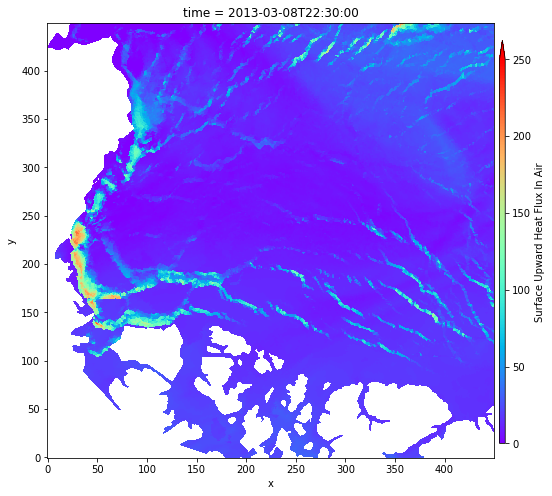

In [55]:

plt.close('all')
Nt=len(dates)
# Plot first frame
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)

cs=varin[0].plot.imshow(ax=ax,vmin=0, vmax=250,cmap=cmap, add_colorbar=False)

cb_title = u"%s" % (ds[var].long_name)
print(cb_title)
cb_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cs, cax=cb_ax, label=cb_title, extend='max')     

# animation function
def animate(frame):
    ax.collections = [] 
    cs=varin[frame].plot.imshow(ax=ax, vmin=0, vmax=250,cmap=cmap, add_colorbar=False)

    #title = u"%s — %s" % (ds[var].long_name, str(dates[frame].values)[:16])
    #plt.title(title)
    return cs    


anim = animation.FuncAnimation(fig, animate, frames=Nt, repeat=False)
outname = outpath_plots+'animate_' + var + '_' + exp[k] + '.gif'
anim.save(outname, writer='imagemagic', fps=8)

